Import ONI data

In [1]:
import pandas as pd
import os
import numpy as np

oni_data = pd.read_csv("oni.txt", sep="\s+")
oni_data

,YR,MON,TOTAL,ClimAdjust,ANOM
0,1950,1,24.56,26.18,-1.62
1,1950,2,25.07,26.39,-1.32
2,1950,3,25.88,26.95,-1.07
3,1950,4,26.29,27.39,-1.11
4,1950,5,26.19,27.56,-1.37
...,...,...,...,...,...
893,2024,6,27.91,27.73,0.18
894,2024,7,27.34,27.29,0.05
895,2024,8,26.74,26.86,-0.11
896,2024,9,26.47,26.72,-0.25


Import DID/MET data

In [5]:
import pandas as pd
import os
import re
folder_path = "bintulu"
precipitation_data = pd.DataFrame()
for file in os.listdir(folder_path):
    if re.search(r"rainfall-data\d*\.csv", file):
        df = pd.read_csv(f"{folder_path}/{file}")
        precipitation_data = pd.concat([precipitation_data, df], ignore_index=True)
    else:
        continue

In [ ]:
precipitation_data["DateTime"] = pd.to_datetime(precipitation_data["DateTime"],format="%Y%m%d %H%M")
precipitation_data = precipitation_data[["DateTime", "Rainfall (mm)"]]
precipitation_data.rename(columns={"Rainfall (mm)": "Rainfall"}, inplace=True)
precipitation_data

ValueError: time data "01/01/2012" doesn't match format "%Y%m%d %H%M", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Merge DID and ONI data

In [130]:
precipitation_data = pd.merge(
    precipitation_data,
    oni_data[["YR", "MON", "TOTAL", "ClimAdjust", "ANOM"]],
    left_on=[precipitation_data["DateTime"].dt.year, precipitation_data["DateTime"].dt.month],
    right_on= ["YR", "MON"]
).drop(["YR", "MON"], axis=1)
precipitation_data.set_index("DateTime",inplace=True)

precipitation_data


,Rainfall,TOTAL,ClimAdjust,ANOM
DateTime,,,,
2010-11-25 11:00:00,0.0,25.06,26.70,-1.64
2010-11-25 12:00:00,0.0,25.06,26.70,-1.64
2010-11-25 13:00:00,0.0,25.06,26.70,-1.64
2010-11-25 14:00:00,0.0,25.06,26.70,-1.64
2010-11-25 15:00:00,0.0,25.06,26.70,-1.64
...,...,...,...,...
2022-07-17 07:00:00,0.0,26.60,27.29,-0.70
2022-07-17 08:00:00,0.0,26.60,27.29,-0.70
2022-07-17 09:00:00,0.0,26.60,27.29,-0.70


Import Wunderground data

In [131]:
feature_data = pd.read_csv(f"{folder_path}/rainfall-feature-wunderground.csv")
feature_data.rename(columns={"Time":"DateTime"},inplace=True)
feature_data["DateTime"] = pd.to_datetime(feature_data["DateTime"], format="%Y-%m-%d %H:%M:%S%z")
feature_data["DateTime"] = feature_data["DateTime"].dt.tz_localize(None)
feature_data.set_index("DateTime",inplace=True)
# feature_data.drop(columns={"Wind Gust", "Precip."}, inplace=True)
feature_data.fillna({"Wind Speed":0}, inplace=True)
feature_data.ffill(inplace=True)
feature_data.rename(columns={"Dew Point": "DewPoint", "Wind Speed": "WindSpeed", "Wind Direction": "WindDir"}, inplace=True)
feature_data

,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir
DateTime,,,,,,,
2002-08-01 00:00:00,75.0,73.0,94.0,6.0,1.0,29.72,40.0
2002-08-01 01:00:00,75.0,75.0,100.0,6.0,0.0,29.72,40.0
2002-08-01 02:00:00,75.0,73.0,94.0,6.0,3.0,29.69,40.0
2002-08-01 03:00:00,75.0,73.0,94.0,6.0,0.0,29.69,40.0
2002-08-01 04:00:00,73.0,73.0,100.0,6.0,9.0,29.66,40.0
...,...,...,...,...,...,...,...
2024-12-31 19:00:00,84.0,77.0,79.0,6.0,6.0,29.67,270.0
2024-12-31 20:00:00,84.0,77.0,79.0,6.0,6.0,29.70,270.0
2024-12-31 21:00:00,82.0,77.0,84.0,6.0,6.0,29.73,260.0


Combine all data

In [132]:
lawas_rainfall = precipitation_data.join(feature_data)
# lawas_rainfall.dropna(inplace=True)
lawas_rainfall

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir
DateTime,,,,,,,,,,,
2010-11-25 11:00:00,0.0,25.06,26.70,-1.64,84.0,73.0,70.0,6.0,8.0,29.75,190.0
2010-11-25 12:00:00,0.0,25.06,26.70,-1.64,86.0,73.0,66.0,6.0,10.0,29.69,180.0
2010-11-25 13:00:00,0.0,25.06,26.70,-1.64,88.0,73.0,62.0,6.0,12.0,29.66,170.0
2010-11-25 14:00:00,0.0,25.06,26.70,-1.64,90.0,73.0,59.0,6.0,10.0,29.63,150.0
2010-11-25 15:00:00,0.0,25.06,26.70,-1.64,90.0,73.0,59.0,6.0,12.0,29.60,180.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-17 07:00:00,0.0,26.60,27.29,-0.70,77.0,75.0,94.0,6.0,2.0,29.79,120.0
2022-07-17 08:00:00,0.0,26.60,27.29,-0.70,81.0,77.0,89.0,6.0,5.0,29.79,200.0
2022-07-17 09:00:00,0.0,26.60,27.29,-0.70,75.0,73.0,94.0,6.0,12.0,29.82,220.0


Check for duplicate data

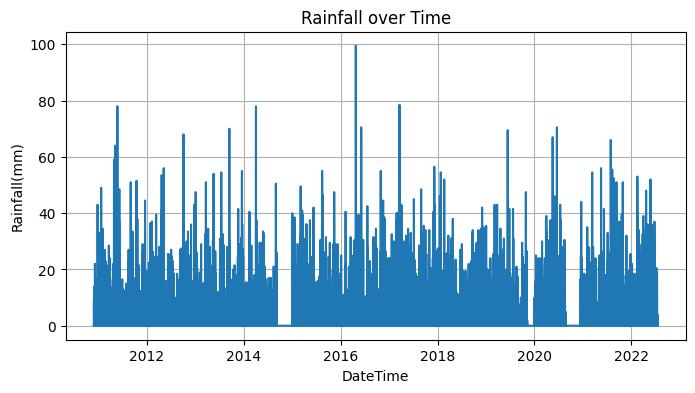

In [133]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(lawas_rainfall.index, lawas_rainfall["Rainfall"])
plt.title(f'Rainfall over Time')
plt.xlabel('DateTime')
plt.ylabel("Rainfall(mm)")
# plt.xlim(pd.Timestamp("2021-02-01"), pd.Timestamp("2022-02-01"))
plt.grid(True)
plt.show()

In [134]:
duplicates = lawas_rainfall.index[lawas_rainfall.index.duplicated()]
if not duplicates.empty:
    print("Duplicate timestamps found:", duplicates)
    numeric_cols = lawas_rainfall.select_dtypes(include=['number']).columns
    non_numeric_cols = lawas_rainfall.select_dtypes(exclude=['number']).columns

    # Handle duplicate index by grouping
    # For numeric columns, take the mean
    # For non-numeric columns, take the first occurrence (or other appropriate method)
    lawas_rainfall = (
        lawas_rainfall.groupby(lawas_rainfall.index)
        .agg({**{col: 'mean' for col in numeric_cols},
            **{col: 'first' for col in non_numeric_cols}})
    )

lawas_rainfall

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir
DateTime,,,,,,,,,,,
2010-11-25 11:00:00,0.0,25.06,26.70,-1.64,84.0,73.0,70.0,6.0,8.0,29.75,190.0
2010-11-25 12:00:00,0.0,25.06,26.70,-1.64,86.0,73.0,66.0,6.0,10.0,29.69,180.0
2010-11-25 13:00:00,0.0,25.06,26.70,-1.64,88.0,73.0,62.0,6.0,12.0,29.66,170.0
2010-11-25 14:00:00,0.0,25.06,26.70,-1.64,90.0,73.0,59.0,6.0,10.0,29.63,150.0
2010-11-25 15:00:00,0.0,25.06,26.70,-1.64,90.0,73.0,59.0,6.0,12.0,29.60,180.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-17 07:00:00,0.0,26.60,27.29,-0.70,77.0,75.0,94.0,6.0,2.0,29.79,120.0
2022-07-17 08:00:00,0.0,26.60,27.29,-0.70,81.0,77.0,89.0,6.0,5.0,29.79,200.0
2022-07-17 09:00:00,0.0,26.60,27.29,-0.70,75.0,73.0,94.0,6.0,12.0,29.82,220.0


Add Topographic data

In [135]:
topo_loc = {
    "lawas":
    {
        "lat": 4.847301, "lon": 115.406703, "elev": 6.5,
    },
    "mulu":
    {
        "lat": 4.049213, "lon": 114.810996, "elev": 28.7,
    },
    "kuching":
    {
        "lat": 1.487123, "lon": 110.341599, "elev": 22.3,
    },
    "kota-kinabalu":
    {
        "lat": 5.923283, "lon": 116.051239, "elev": 5.4,
    },
    "kuantan":
    {
        "lat": 3.780726, "lon": 103.215062, "elev": 16,
    },
    "miri":
    {
        "lat": 4.322991, "lon": 113.987416, "elev": 19,
    }

}

# Add topographic data to the DataFrame
location = folder_path.lower()
if location in topo_loc:
    lawas_rainfall["Latitude"] = topo_loc[location]["lat"]
    lawas_rainfall["Longitude"] = topo_loc[location]["lon"]
    lawas_rainfall["Elevation"] = topo_loc[location]["elev"]
print(lawas_rainfall.head())

                     Rainfall  TOTAL  ClimAdjust  ANOM  Temperature  DewPoint  \
DateTime                                                                        
2010-11-25 11:00:00       0.0  25.06        26.7 -1.64         84.0      73.0   
2010-11-25 12:00:00       0.0  25.06        26.7 -1.64         86.0      73.0   
2010-11-25 13:00:00       0.0  25.06        26.7 -1.64         88.0      73.0   
2010-11-25 14:00:00       0.0  25.06        26.7 -1.64         90.0      73.0   
2010-11-25 15:00:00       0.0  25.06        26.7 -1.64         90.0      73.0   

                     Humidity  Visibility  WindSpeed  Pressure  WindDir  \
DateTime                                                                  
2010-11-25 11:00:00      70.0         6.0        8.0     29.75    190.0   
2010-11-25 12:00:00      66.0         6.0       10.0     29.69    180.0   
2010-11-25 13:00:00      62.0         6.0       12.0     29.66    170.0   
2010-11-25 14:00:00      59.0         6.0       10.0     

Find the data losses (Training Input)

In [136]:
datetime_range = pd.date_range(start=lawas_rainfall.index.min(), end=lawas_rainfall.index.max(), freq='1h')

missing_date = datetime_range.difference(lawas_rainfall.index)
missing_date

DatetimeIndex(['2019-11-09 01:00:00', '2019-11-09 02:00:00',
               '2019-11-09 03:00:00', '2019-11-09 04:00:00',
               '2019-11-09 05:00:00', '2019-11-09 06:00:00',
               '2019-11-09 07:00:00', '2019-11-09 08:00:00',
               '2019-11-09 09:00:00', '2019-11-09 10:00:00',
               ...
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00',
               '2019-12-31 21:00:00', '2019-12-31 22:00:00',
               '2019-12-31 23:00:00', '2022-02-14 01:00:00'],
              dtype='datetime64[ns]', length=1272, freq=None)

In [137]:
# start_date_input = "2020-01-01"
# end_date_input = "2022-07-17 11:00:00"

start_date_input = "2010-11-26"
end_date_input = "2019-11-08"
# There is data losses from Feb 2021 - Dec 2021, as there is major loss. The data will be use from Aug 2002 until Jan 2021

missing_date_input = missing_date[(missing_date >= start_date_input) & (missing_date <= end_date_input)]
missing_date_input

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [138]:
lawas_rainfall_input = lawas_rainfall.reindex(
                    pd.date_range(start=start_date_input, end=end_date_input,
                    freq='1h'),
                    method='ffill'
                    )
lawas_rainfall_input.index.name = "DateTime"
lawas_rainfall_input

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2010-11-26 00:00:00,9.0,25.06,26.7,-1.64,82.0,75.0,79.0,6.0,7.0,29.66,250.0,4.049213,114.810996,28.7
2010-11-26 01:00:00,3.0,25.06,26.7,-1.64,82.0,77.0,84.0,6.0,7.0,29.66,250.0,4.049213,114.810996,28.7
2010-11-26 02:00:00,0.0,25.06,26.7,-1.64,81.0,77.0,89.0,6.0,5.0,29.63,260.0,4.049213,114.810996,28.7
2010-11-26 03:00:00,1.5,25.06,26.7,-1.64,79.0,77.0,94.0,6.0,1.0,29.66,350.0,4.049213,114.810996,28.7
2010-11-26 04:00:00,1.0,25.06,26.7,-1.64,75.0,73.0,94.0,6.0,2.0,29.66,60.0,4.049213,114.810996,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-07 20:00:00,0.0,27.23,26.7,0.52,81.0,77.0,89.0,6.0,1.0,29.75,260.0,4.049213,114.810996,28.7
2019-11-07 21:00:00,0.0,27.23,26.7,0.52,81.0,77.0,89.0,6.0,6.0,29.78,100.0,4.049213,114.810996,28.7
2019-11-07 22:00:00,0.0,27.23,26.7,0.52,79.0,77.0,94.0,6.0,2.0,29.78,100.0,4.049213,114.810996,28.7


In [139]:
# Check on start and end data
print(f"Head Data:\n{lawas_rainfall_input.head()}\n")
print(f"Tail Data:\n{lawas_rainfall_input.tail()}")

Head Data:
                     Rainfall  TOTAL  ClimAdjust  ANOM  Temperature  DewPoint  \
DateTime                                                                        
2010-11-26 00:00:00       9.0  25.06        26.7 -1.64         82.0      75.0   
2010-11-26 01:00:00       3.0  25.06        26.7 -1.64         82.0      77.0   
2010-11-26 02:00:00       0.0  25.06        26.7 -1.64         81.0      77.0   
2010-11-26 03:00:00       1.5  25.06        26.7 -1.64         79.0      77.0   
2010-11-26 04:00:00       1.0  25.06        26.7 -1.64         75.0      73.0   

                     Humidity  Visibility  WindSpeed  Pressure  WindDir  \
DateTime                                                                  
2010-11-26 00:00:00      79.0         6.0        7.0     29.66    250.0   
2010-11-26 01:00:00      84.0         6.0        7.0     29.66    250.0   
2010-11-26 02:00:00      89.0         6.0        5.0     29.63    260.0   
2010-11-26 03:00:00      94.0         6.0     

In [140]:
lawas_rainfall_input.columns

Index(['Rainfall', 'TOTAL', 'ClimAdjust', 'ANOM', 'Temperature', 'DewPoint',
       'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir',
       'Latitude', 'Longitude', 'Elevation'],
      dtype='object')

In [141]:
def resultant_wind_direction(x):
    radians = np.deg2rad(x)

    mean_sin = np.mean(np.sin(radians))
    mean_cos = np.mean(np.cos(radians))

    resultant_radians = np.arctan2(mean_sin, mean_cos)
    resultant_degrees = np.rad2deg(resultant_radians) % 360
    
    return resultant_degrees

Downsample data - daily, weekly

In [142]:
lawas_rainfall_input_daily = lawas_rainfall_input.resample('D').agg({
    'Rainfall': 'sum',
    'TOTAL': 'mean',
    'ClimAdjust': 'mean',
    'ANOM': 'mean',
    'Temperature': 'mean',
    'DewPoint': 'mean',
    'Humidity': 'mean',
    'Visibility': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean',
    'WindDir': resultant_wind_direction,
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Elevation': 'mean',
    # 'Condition': lambda x: x.mode()[0]
})

lawas_rainfall_input_weekly = lawas_rainfall_input.resample('W').agg({
    'Rainfall': 'sum',
    'TOTAL': 'mean',
    'ClimAdjust': 'mean',
    'ANOM': 'mean',
    'Temperature': 'mean',
    'DewPoint': 'mean',
    'Humidity': 'mean',
    'Visibility': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean',
    'WindDir': resultant_wind_direction,
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Elevation': 'mean',
    # 'Condition': lambda x: x.mode()[0]
})

lawas_rainfall_input_daily = lawas_rainfall_input_daily.ffill()
lawas_rainfall_input_weekly = lawas_rainfall_input_weekly.ffill()

In [143]:
lawas_rainfall_input_daily

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2010-11-26,16.0,25.06,26.7,-1.64,81.090909,74.909091,82.409091,6.000000,5.909091,29.668182,224.000780,4.049213,114.810996,28.7
2010-11-27,16.0,25.06,26.7,-1.64,79.875000,74.416667,84.500000,6.000000,5.750000,29.683750,57.239884,4.049213,114.810996,28.7
2010-11-28,8.0,25.06,26.7,-1.64,80.826087,76.130435,86.217391,6.000000,4.173913,29.671739,27.028382,4.049213,114.810996,28.7
2010-11-29,11.5,25.06,26.7,-1.64,81.125000,76.666667,86.750000,6.000000,4.708333,29.637500,275.746991,4.049213,114.810996,28.7
2010-11-30,17.5,25.06,26.7,-1.64,78.181818,75.545455,91.954545,5.681818,5.590909,29.619091,166.150255,4.049213,114.810996,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-04,3.5,27.23,26.7,0.52,82.166667,77.166667,85.458333,5.875000,5.625000,29.755000,218.110195,4.049213,114.810996,28.7
2019-11-05,55.0,27.23,26.7,0.52,81.541667,76.666667,85.750000,5.916667,6.708333,29.716250,222.441059,4.049213,114.810996,28.7
2019-11-06,4.0,27.23,26.7,0.52,77.750000,75.083333,92.041667,5.208333,4.000000,29.718750,210.730828,4.049213,114.810996,28.7


In [144]:
lawas_rainfall_input_weekly

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2010-11-28,40.0,25.060000,26.700000,-1.640000,80.579710,75.144928,84.405797,6.000000,5.275362,29.674783,42.671685,4.049213,114.810996,28.7
2010-12-05,136.0,25.017143,26.628571,-1.611429,79.918239,75.685535,87.616352,5.814465,4.754717,29.621698,232.560949,4.049213,114.810996,28.7
2010-12-12,130.0,25.000000,26.600000,-1.600000,79.212500,73.593750,83.956250,5.818750,6.793750,29.654750,194.623463,4.049213,114.810996,28.7
2010-12-19,51.0,25.000000,26.600000,-1.600000,78.950617,74.209877,86.111111,5.804012,4.462963,29.670185,198.137694,4.049213,114.810996,28.7
2010-12-26,116.5,25.000000,26.600000,-1.600000,78.782609,73.478261,85.000000,5.887764,5.459627,29.651056,168.942669,4.049213,114.810996,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-13,32.0,27.200000,26.720000,0.480000,80.720238,76.238095,87.053571,5.892857,3.904762,29.738571,250.479258,4.049213,114.810996,28.7
2019-10-20,56.0,27.200000,26.720000,0.480000,82.375000,77.523810,85.839286,5.964286,4.636905,29.726429,109.411018,4.049213,114.810996,28.7
2019-10-27,88.5,27.200000,26.720000,0.480000,81.404762,77.613095,88.797619,5.660714,4.208333,29.694821,197.522551,4.049213,114.810996,28.7


In [145]:
lawas_rainfall_input

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2010-11-26 00:00:00,9.0,25.06,26.7,-1.64,82.0,75.0,79.0,6.0,7.0,29.66,250.0,4.049213,114.810996,28.7
2010-11-26 01:00:00,3.0,25.06,26.7,-1.64,82.0,77.0,84.0,6.0,7.0,29.66,250.0,4.049213,114.810996,28.7
2010-11-26 02:00:00,0.0,25.06,26.7,-1.64,81.0,77.0,89.0,6.0,5.0,29.63,260.0,4.049213,114.810996,28.7
2010-11-26 03:00:00,1.5,25.06,26.7,-1.64,79.0,77.0,94.0,6.0,1.0,29.66,350.0,4.049213,114.810996,28.7
2010-11-26 04:00:00,1.0,25.06,26.7,-1.64,75.0,73.0,94.0,6.0,2.0,29.66,60.0,4.049213,114.810996,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-07 20:00:00,0.0,27.23,26.7,0.52,81.0,77.0,89.0,6.0,1.0,29.75,260.0,4.049213,114.810996,28.7
2019-11-07 21:00:00,0.0,27.23,26.7,0.52,81.0,77.0,89.0,6.0,6.0,29.78,100.0,4.049213,114.810996,28.7
2019-11-07 22:00:00,0.0,27.23,26.7,0.52,79.0,77.0,94.0,6.0,2.0,29.78,100.0,4.049213,114.810996,28.7


Data for validation

In [146]:
start_date_valid = "2020-01-01"
end_date_valid = "2022-07-16"
# There is data losses from Feb 2021 - Dec 2021, as there is major loss. The data will be use from Jan 2002 until Apr 2021

missing_date_valid = missing_date[(missing_date >= start_date_valid) & (missing_date <= end_date_valid)]

In [147]:
lawas_rainfall_valid = lawas_rainfall.reindex(
                    pd.date_range(start=start_date_valid, end=end_date_valid,
                    freq='1h'),
                    method='ffill'
                    )
lawas_rainfall_valid.index.name = "DateTime"
lawas_rainfall_valid

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,27.16,26.55,0.6,79.0,77.0,94.0,6.0,3.0,29.78,50.0,4.049213,114.810996,28.7
2020-01-01 01:00:00,0.0,27.16,26.55,0.6,77.0,77.0,100.0,6.0,2.0,29.78,50.0,4.049213,114.810996,28.7
2020-01-01 02:00:00,0.0,27.16,26.55,0.6,77.0,77.0,100.0,6.0,2.0,29.75,50.0,4.049213,114.810996,28.7
2020-01-01 03:00:00,0.0,27.16,26.55,0.6,77.0,77.0,100.0,6.0,1.0,29.75,50.0,4.049213,114.810996,28.7
2020-01-01 04:00:00,0.0,27.16,26.55,0.6,77.0,77.0,100.0,6.0,2.0,29.72,50.0,4.049213,114.810996,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-15 20:00:00,0.0,26.60,27.29,-0.7,81.0,77.0,89.0,6.0,6.0,29.73,250.0,4.049213,114.810996,28.7
2022-07-15 21:00:00,0.0,26.60,27.29,-0.7,79.0,75.0,89.0,6.0,3.0,29.73,260.0,4.049213,114.810996,28.7
2022-07-15 22:00:00,0.0,26.60,27.29,-0.7,79.0,75.0,89.0,6.0,2.0,29.73,260.0,4.049213,114.810996,28.7


In [148]:
# Check on start and end data
print(f"Head Data:\n{lawas_rainfall_valid.head()}\n")
print(f"Tail Data:\n{lawas_rainfall_valid.tail()}")

Head Data:
                     Rainfall  TOTAL  ClimAdjust  ANOM  Temperature  DewPoint  \
DateTime                                                                        
2020-01-01 00:00:00       0.0  27.16       26.55   0.6         79.0      77.0   
2020-01-01 01:00:00       0.0  27.16       26.55   0.6         77.0      77.0   
2020-01-01 02:00:00       0.0  27.16       26.55   0.6         77.0      77.0   
2020-01-01 03:00:00       0.0  27.16       26.55   0.6         77.0      77.0   
2020-01-01 04:00:00       0.0  27.16       26.55   0.6         77.0      77.0   

                     Humidity  Visibility  WindSpeed  Pressure  WindDir  \
DateTime                                                                  
2020-01-01 00:00:00      94.0         6.0        3.0     29.78     50.0   
2020-01-01 01:00:00     100.0         6.0        2.0     29.78     50.0   
2020-01-01 02:00:00     100.0         6.0        2.0     29.75     50.0   
2020-01-01 03:00:00     100.0         6.0     

In [149]:
lawas_rainfall_valid.columns

Index(['Rainfall', 'TOTAL', 'ClimAdjust', 'ANOM', 'Temperature', 'DewPoint',
       'Humidity', 'Visibility', 'WindSpeed', 'Pressure', 'WindDir',
       'Latitude', 'Longitude', 'Elevation'],
      dtype='object')

Downsample for validation data

In [150]:
lawas_rainfall_valid_daily = lawas_rainfall_valid.resample('D').agg({
    'Rainfall': 'sum',
    'TOTAL': 'mean',
    'ClimAdjust': 'mean',
    'ANOM': 'mean',
    'Temperature': 'mean',
    'DewPoint': 'mean',
    'Humidity': 'mean',
    'Visibility': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean',
    'WindDir': resultant_wind_direction,
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Elevation': 'mean',
    # 'Condition': lambda x: x.mode()[0]
})

lawas_rainfall_valid_weekly = lawas_rainfall_valid.resample('W').agg({
    'Rainfall': 'sum',
    'TOTAL': 'mean',
    'ClimAdjust': 'mean',
    'ANOM': 'mean',
    'Temperature': 'mean',
    'DewPoint': 'mean',
    'Humidity': 'mean',
    'Visibility': 'mean',
    'WindSpeed': 'mean',
    'Pressure': 'mean',
    'WindDir': resultant_wind_direction,
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Elevation': 'mean',
    # 'Condition': lambda x: x.mode()[0]
})

lawas_rainfall_valid_daily = lawas_rainfall_valid_daily.ffill()
lawas_rainfall_valid_weekly = lawas_rainfall_valid_weekly.ffill()

In [151]:
lawas_rainfall_valid_daily

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2020-01-01,21.0,27.16,26.55,0.6,81.833333,78.583333,90.250000,6.000000,5.083333,29.776250,50.014833,4.049213,114.810996,28.7
2020-01-02,2.5,27.16,26.55,0.6,82.000000,77.833333,88.041667,5.916667,6.708333,29.801250,55.071301,4.049213,114.810996,28.7
2020-01-03,2.0,27.16,26.55,0.6,81.347826,78.043478,90.000000,6.000000,6.826087,29.761739,40.738349,4.049213,114.810996,28.7
2020-01-04,0.5,27.16,26.55,0.6,80.625000,76.916667,89.041667,6.000000,9.250000,29.708750,52.641191,4.049213,114.810996,28.7
2020-01-05,0.0,27.16,26.55,0.6,81.833333,77.916667,88.583333,5.666667,4.750000,29.700000,68.442337,4.049213,114.810996,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,3.0,26.60,27.29,-0.7,79.541667,74.833333,85.541667,6.000000,5.291667,29.706250,123.430201,4.049213,114.810996,28.7
2022-07-13,16.5,26.60,27.29,-0.7,77.333333,75.083333,93.583333,5.625000,5.166667,29.711250,212.507900,4.049213,114.810996,28.7
2022-07-14,34.5,26.60,27.29,-0.7,79.458333,75.750000,89.041667,6.000000,4.666667,29.722500,193.207297,4.049213,114.810996,28.7


In [152]:
lawas_rainfall_valid_weekly

,Rainfall,TOTAL,ClimAdjust,ANOM,Temperature,DewPoint,Humidity,Visibility,WindSpeed,Pressure,WindDir,Latitude,Longitude,Elevation
DateTime,,,,,,,,,,,,,,
2020-01-05,26.0,27.160000,26.550000,0.600000,81.529412,77.857143,89.176471,5.915966,6.521008,29.749496,53.076589,4.049213,114.810996,28.7
2020-01-12,148.0,27.160000,26.550000,0.600000,80.678571,77.571429,90.767857,5.857143,5.392857,29.697679,50.554571,4.049213,114.810996,28.7
2020-01-19,52.5,27.160000,26.550000,0.600000,80.690476,77.714286,90.916667,5.809524,4.065476,29.737857,64.202649,4.049213,114.810996,28.7
2020-01-26,18.0,27.160000,26.550000,0.600000,81.922619,78.571429,89.928571,5.880952,4.678571,29.760536,33.564171,4.049213,114.810996,28.7
2020-02-02,125.5,27.151429,26.610000,0.534286,81.672619,77.017857,86.910714,5.976190,6.559524,29.768155,44.250941,4.049213,114.810996,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-19,146.5,26.980000,27.730000,-0.750000,79.952381,76.690476,90.273810,5.853036,4.404762,29.731786,331.110723,4.049213,114.810996,28.7
2022-06-26,147.5,26.980000,27.730000,-0.750000,80.345238,76.660714,88.976190,5.880952,4.172619,29.706250,252.005355,4.049213,114.810996,28.7
2022-07-03,68.5,26.817143,27.541429,-0.728571,82.255952,77.119048,85.285714,5.940476,5.077381,29.666250,199.116854,4.049213,114.810996,28.7


Export as .csv file

In [153]:
# input data
lawas_rainfall_input.to_csv(f"{folder_path}/{folder_path}-rainfall.csv",index=True)
lawas_rainfall_input_daily.to_csv(f"{folder_path}/{folder_path}-rainfall-daily.csv",index=True)
lawas_rainfall_input_weekly.to_csv(f"{folder_path}/{folder_path}-rainfall-weekly.csv",index=True)

# valid data
lawas_rainfall_valid.to_csv(f"valid/{folder_path}-rainfall-valid.csv",index=True)
lawas_rainfall_valid_daily.to_csv(f"valid/{folder_path}-rainfall-valid-daily.csv",index=True)
lawas_rainfall_valid_weekly.to_csv(f"valid/{folder_path}-rainfall-valid-weekly.csv",index=True)